In [ ]:
import pandas_datareader as DataReader

In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf

In [ ]:
ef = yf.download('INFY.NS','2013-04-01','2023-03-31')

[*********************100%***********************]  1 of 1 completed


In [ ]:
ef_close = ef['Close']

In [ ]:
ef_close.head()

Date
2013-04-01    368.024994
2013-04-02    371.131256
2013-04-03    371.056244
2013-04-04    360.006256
2013-04-05    358.231262
Name: Close, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

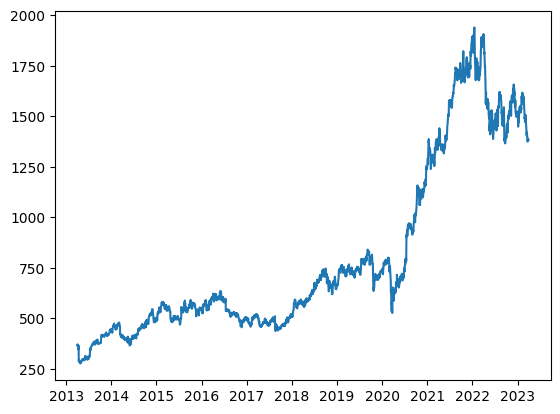

In [ ]:
plt.plot(ef_close)
plt.show()

In [ ]:
ef_close = np.array(ef_close)

In [ ]:
seq_length = 10
pred_seq = 5
X = []
Y = []

for idx in range(int(2467/pred_seq) - 2):
   X.append(ef_close[idx*pred_seq: idx*pred_seq + seq_length])
   Y.append(ef_close[idx*pred_seq + seq_length: idx*pred_seq + seq_length + pred_seq])

X = np.array(X)
Y = np.array(Y)

In [ ]:
X.shape, Y.shape

((491, 10), (491, 5))

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

In [ ]:
(x_train, x_test),(y_train, y_test) = ((X[:400,:], X[400:,:]), (Y[:400,:], Y[400:,:]))

In [ ]:
x_train.shape

(400, 10)

In [ ]:
train_loader = DataLoader(TensorDataset(torch.tensor(x_train).reshape(-1,10,1).float(),\
                                        torch.tensor(y_train).reshape(-1,5).float()),
                          batch_size = 32, shuffle = True)

x_test, y_test = (torch.tensor(x_test).reshape(-1,10,1).float(),
                  torch.tensor(y_test).reshape(-1,5).float())

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
device

device(type='cuda')

In [ ]:
class LSTMnet(nn.Module):
  def __init__(self):
    super(LSTMnet, self).__init__()
    self.lstm = nn.LSTM(input_size = 1, hidden_size = 128, batch_first = True,
                        num_layers = 2, dropout = 0.3)
    self.bn1 = nn.BatchNorm1d(num_features = 128)
    self.fc1 = nn.Linear(in_features = 128, out_features = 64)
    self.fc2 = nn.Linear(in_features = 64, out_features = 5)

  # Return array/weights initialized to 0 matching hidden size
  def initialize(self, batch_size):
    return(torch.zeros(2, batch_size, 128).to(device),
           torch.zeros(2, batch_size, 128).to(device))
    
  def forward(self, x):
    x, s = self.lstm(x, self.initialize(x.size()[0]))
    # print(x.size())
    x = x[:, -1, :] # won't see in MLP, DNN, CNN.
                    # [Batch, outcome of last cell, something batch normalisation]
                    # Only interested in the last one not intermediate ones.
                    # This is seen from the -1 argument passed to x[]
    x = self.bn1(x)

    x = F.relu(self.fc1(x)) # Don't have negative values for price
                            # Therefore Relu good candidate than tanh or sigmoid
                            # Ultimately dealing with regression problem
                            # For profit, can have negative or positive
                            # Leaky Relu preferable
                            # For standardised profit, tanh can be good candidate.
    x = self.fc2(x)
    # print(x.size())
    return x

In [ ]:
model = LSTMnet()
opt = Adam(model.parameters(), lr=0.001)

In [ ]:
from torchinfo import summary as summary

In [ ]:
summary(model, input_size = (32, 10, 1), device = 'cuda')

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
LSTMnet                                  [32, 5]                   --
├─LSTM: 1-1                              [32, 10, 128]             199,168
├─BatchNorm1d: 1-2                       [32, 128]                 256
├─Linear: 1-3                            [32, 64]                  8,256
├─Linear: 1-4                            [32, 5]                   325
Total params: 208,005
Trainable params: 208,005
Non-trainable params: 0
Total mult-adds (M): 64.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.83
Estimated Total Size (MB): 1.21

In [ ]:
epochs = 1000
model = model.to(device)

for epoch in range(epochs):
  train_loss = 0.0
  val_loss = 0.0
  
  for batch, target in train_loader:
    batch = batch.to(device)
    target = target.to(device)

    opt.zero_grad()
    output = model(batch)
    loss = F.mse_loss(output, target)
    loss.backward()
    opt.step()
    train_loss = train_loss + loss.item()

    with torch.no_grad():
      x_test = x_test.to(device)
      y_test = y_test.to(device)
      val_output = model(x_test)
      loss_val = F.mse_loss(val_output, y_test)
      val_loss = val_loss + loss_val.item()

      if(epoch+1)%10==0:
        print(f"Train loss: {train_loss} and Val loss: {val_loss}")


Train loss: 291707.96875 and Val loss: 2505448.25
Train loss: 711620.46875 and Val loss: 5005081.0
Train loss: 1003451.21875 and Val loss: 7502064.0
Train loss: 1350837.3125 and Val loss: 10001895.5
Train loss: 1591058.234375 and Val loss: 12483591.0
Train loss: 1878698.484375 and Val loss: 14952603.25
Train loss: 2207440.640625 and Val loss: 17400949.0
Train loss: 2436559.34375 and Val loss: 19862870.75
Train loss: 2675091.140625 and Val loss: 22340435.5
Train loss: 2982768.296875 and Val loss: 24806076.25
Train loss: 3280844.265625 and Val loss: 27283516.75
Train loss: 3478223.640625 and Val loss: 29752048.25
Train loss: 3780372.953125 and Val loss: 32221903.5
Train loss: 87561.8046875 and Val loss: 1980415.75
Train loss: 143648.14453125 and Val loss: 3989568.875
Train loss: 255687.28515625 and Val loss: 5988381.5
Train loss: 327591.12109375 and Val loss: 8031689.0
Train loss: 490333.07421875 and Val loss: 10082075.5
Train loss: 592069.78515625 and Val loss: 12123484.25
Train loss: 6